In [366]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [396]:
from mtr.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from mtr.datasets.waymo.waymo_dataset_bc import WaymoDatasetBC
from tools.mtr_env import BatchMTREnv
from tools.mtr_inference import MTRInference
from tools.mtr_lightning import MTR_Lightning
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical, Independent

cfg = cfg_from_yaml_file('tools/cfgs/waymo/bc+10_percent_data.yaml', cfg)
dataset = WaymoDatasetBC(cfg.DATA_CONFIG, training=True)
env = BatchMTREnv(1, dataset)

model = MTR_Lightning(cfg)
model = model.load_from_checkpoint('output/bc/epoch=29-step=92010.ckpt')
model = model.eval()

torch.Size([64, 512])
torch.Size([6, 512])


# Test with dataset

In [394]:
data = dataset[1]
data_batch = dataset.collate_batch([data])
gt = data_batch['input_dict']['center_gt']
mode, mix, gmm, sample = model.sample(data_batch)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 data = dataset[1]                                                                            │
│   2 data_batch = dataset.collate_batch([data])                                                   │
│   3 gt = data_batch['input_dict']['center_gt']                                                   │
│ ❱ 4 mode, mix, gmm, sample = model.sample(data_batch)                                            │
│   5                                                                                              │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/tools/mtr_lightning.py:125 in sample                           │
│                                                                                                  │
│   122 │   def sample(self, batch):                                                               │
│   123 │   │   self.eval()                                                                        │
│   124 │   │   with torch.no_grad():                                                              │
│ ❱ 125 │   │   │   batch_dict = self.model(batch, get_loss=False)                                 │
│   126 │   │   │   pred_scores, pred_ctrls = batch_dict['pred_list'][-1]                          │
│   127 │   │   │   mode, mix, gmm = self.model.motion_decoder.build_mode_distribution(pred_ctrl   │
│   128 │   │   │   # batch_size = pred_scores.shape[0]                                            │
│                                                                                                  │
│ /home/zixuzhang/mambaforge/envs/lpp/lib/python3.9/site-packages/torch/nn/modules/module.py:1501  │
│ in _call_impl                                                                                    │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1501 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1502 │   │   # Do not call functions when jit is used                                          │
│   1503 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1504 │   │   backward_pre_hooks = []                                                           │
│                                                                                                  │
│ /home/zixuzhang/Documents/Git/MTR/mtr/models/model.py:28 in forward                              │
│                                                                                                  │
│    25 │   │   )                                                                                  │
│    26 │                                                                                          │
│    27 │   def forward(self, batch_dict, get_loss=True):                                          │
│ ❱  28 │   │   batch_dict = self.context_encoder(batch_dict)                                      │
│    29 │   │   batch_dict = self.motion_decoder(batch_dict)                                       │
│    30 │   │                                                                                      │
│    31 │   │   if get_loss:                                                                       │
│                                                            

In [385]:
print(gt)

tensor([[ 0.3045, -0.0157,  0.0184,  3.0446, -0.1566],
        [ 0.0843, -0.0434, -0.0391,  0.8429, -0.4338],
        [ 0.2685,  0.0041,  0.0107,  2.6853,  0.0409],
        [ 0.1215, -0.0069,  0.0076,  1.2151, -0.0695]])


In [386]:
print(mix)

Categorical(probs: torch.Size([4, 6]), logits: torch.Size([4, 6]))


# Test in simulation

In [368]:
env.reset()

[[ 0.16577102  0.00290607 -0.00236716]
 [ 1.1188211  -0.01359094 -0.00830039]
 [-0.01908647  0.01530136  0.01084294]]


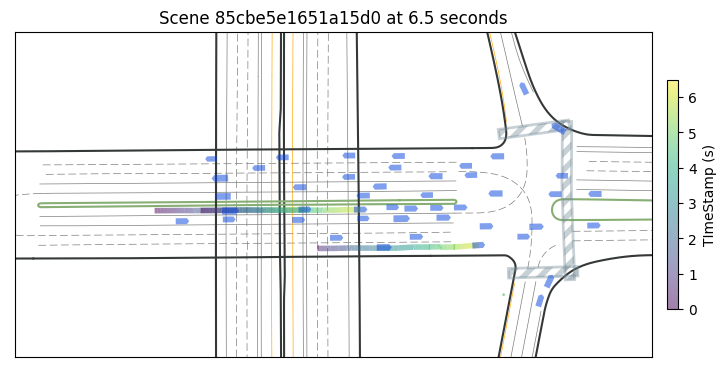

In [365]:
data_batch = env.batch_scene_data
action = model.sample(data_batch)
env.visualize()
print(action)
_ = env.step(action)